In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
! pip install mosestokenizer

     |████████████████████████████████| 51kB 4.4MB/s 
  Created wheel for toolwrapper: filename=toolwrapper-0.4.1-cp36-none-any.whl size=2961 sha256=c80714b5126beca5ffcf8d971e3f9ec61ed2672a2789f5d602c7a38a51839774
  Stored in directory: /root/.cache/pip/wheels/54/70/7a/1436781a1ca86997a44ebd4701f5f2bbcdf42320d0e6112e7d
Successfully built toolwrapper


In [3]:
# colab　にmecabを入れる
!apt install aptitude
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3==0.7

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  aptitude-common libcgi-fast-perl libcgi-pm-perl libclass-accessor-perl
  libcwidget3v5 libencode-locale-perl libfcgi-perl libhtml-parser-perl
  libhtml-tagset-perl libhttp-date-perl libhttp-message-perl libio-html-perl
  libio-string-perl liblwp-mediatypes-perl libparse-debianchangelog-perl
  libsigc++-2.0-0v5 libsub-name-perl libtimedate-perl liburi-perl libxapian30
Suggested packages:
  aptitude-doc-en | aptitude-doc apt-xapian-index debtags tasksel
  libcwidget-dev libdata-dump-perl libhtml-template-perl libxml-simple-perl
  libwww-perl xapian-tools
The following NEW packages will be installed:
  aptitude aptitude-common libcgi-fast-perl libcgi-pm-perl
  libclass-accessor-perl libcwidget3v5 libencode-l

In [0]:
import sys
import gc
import os
base_dir = "drive/My Drive/jp_en_translation/".replace("/",os.sep)
#base_dir = "../"
emb_dir = "drive/My Drive/util_data/".replace("/",os.sep)
sys.path.append("/Users/ueki/Desktop/work/jp_en_translation")
sys.path.append("/Users/ueki/Desktop/JP_EN_Transalation")
sys.path.append(base_dir)
sys.path.append("drive/My Drive/jp_en_translation".replace("/",os.sep))

In [5]:
from models.S2S_attention import Seq2Seq
from utils.LangEn import LangEn
from utils.LangJa import LangJa
from utils.build_emb import build_en_emb,build_jp_emb
from utils.preprocess import loadLangs
import numpy as np
from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.preprocessing import sequence
import torch

Using TensorFlow backend.


In [0]:
config={
    "corpus_file":base_dir+"data/jpn.txt",
    "en_col":"description_en",
    "jp_col":"description_jp",
    "mask_token":0,
    "SOS_token":1,
    "EOS_token":2,
    "UNK_token":3,
    "max_features":8000,
    "MAX_LENGTH":20,
    "train_size":15000,
    "val_size":300,
    "batch_size":128,
    "epochs":20,
    "maxlen_enc":20,
    "maxlen_dec":20,
    "n_hidden":500,
    "input_dim":5000,
    "jp_voc":8000,
    "en_voc":5000,
    "output_dim":8000,
    "emb_dim":300,
    "use_enc_emb":False,
    "use_dec_emb":False,
    "validation_split":0.01,
    "trained_param_dir":base_dir+"trained_models/1_lstm_ja_en_01.hdf5",
    "translate_length":20,
    "en_W2V_FILE" : emb_dir+"GoogleNews-vectors-negative300.bin.gz",
    "jp_W2V_FILE":emb_dir+"ja_data/ja.bin",
    "src":"en",
    "trg":"jp",
    "learning_rate":0.001,
}

# train

In [7]:
data=loadLangs(config)

reading lines


In [0]:
val_data = data[config["train_size"]:config["train_size"]+config["val_size"]]
data = data[:config["train_size"]]

In [0]:
EN_lang = LangEn(config)
JP_lang = LangJa(config)

In [0]:
for s in data[config["en_col"]]:
    EN_lang.addSentence(s)

In [0]:
for s in data[config["jp_col"]]:
    JP_lang.addSentence(s)

## input の加工

In [0]:
if config["src"]=="jp":
    src_col=config["jp_col"]
    trg_col=config["en_col"]
    Langs={"src":JP_lang,"trg":EN_lang}
else:
    src_col=config["en_col"]
    trg_col=config["jp_col"]
    Langs={"trg":JP_lang,"src":EN_lang}

In [0]:
input_en = data[src_col]

In [0]:
input_source_lang=data[src_col].apply(lambda x:Langs["src"].word2id(x))
input_target_lang=data[trg_col].apply(lambda x:Langs["trg"].word2id(x))

In [0]:
val_source = val_data[src_col].apply(lambda x:Langs["src"].word2id(x))
val_target = val_data[trg_col].apply(lambda x:Langs["trg"].word2id(x))

In [0]:
input_source_padded=sequence.pad_sequences(input_source_lang,maxlen=config["MAX_LENGTH"],padding="post",truncating="post")
input_target_padded=sequence.pad_sequences(input_target_lang,maxlen=config["MAX_LENGTH"],padding="post",truncating="post")

In [0]:
val_source_padded=sequence.pad_sequences(val_source,maxlen=config["MAX_LENGTH"],padding="post",truncating="post")
val_target_padded=sequence.pad_sequences(val_target,maxlen=config["MAX_LENGTH"],padding="post",truncating="post")

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## create embedding

In [19]:
en_emb = build_en_emb(config,EN_lang.word2index)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


voc-> 5000
UNK_rate 0.03740748149629926


In [20]:
ja_emb = build_jp_emb(config,JP_lang.word2index)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


voc-> 8000
UNK/rate-> 0.6004500562570322


In [0]:
if config["src"]=="en":
    emb={"src_emb":en_emb,"trg_emb":ja_emb}
else:
    emb={"src_emb":ja_emb,"trg_emb":en_emb}

In [22]:
print("enc->",emb["trg_emb"].shape)
print("dec->",emb["src_emb"].shape)

enc-> (8000, 300)
dec-> (5000, 300)


In [0]:
trainer = Seq2Seq(config,enc_emb=emb["src_emb"],dec_emb=emb["trg_emb"])
#trainer = Seq2Seq(config)

train_size:15000 - val_size:300
Epoch 1/20
76 - loss: 0.74801 - val-loss: 0.92432
----------------
Epoch 2/20
76 - loss: 0.61948 - val-loss: 0.97225
----------------
Epoch 3/20
75 - loss: 0.57335 - val-loss: 0.91872
----------------
Epoch 4/20
76 - loss: 0.54706 - val-loss: 0.78772
----------------
Epoch 5/20
77 - loss: 0.52498 - val-loss: 0.84026
----------------
Epoch 6/20
76 - loss: 0.51747 - val-loss: 0.87888
----------------
Epoch 7/20
77 - loss: 0.48685 - val-loss: 0.86486
----------------
Epoch 8/20
76 - loss: 0.47563 - val-loss: 0.73947
----------------
Epoch 9/20
77 - loss: 0.46769 - val-loss: 0.80005
----------------
Epoch 10/20
79 - loss: 0.43713 - val-loss: 0.82014
----------------
Epoch 11/20
75 - loss: 0.42033 - val-loss: 0.90586
----------------
Epoch 12/20
76 - loss: 0.41494 - val-loss: 0.79959
----------------
Epoch 13/20
79 - loss: 0.39356 - val-loss: 0.86843
----------------
Epoch 14/20
77 - loss: 0.40385 - val-loss: 0.87334
----------------
Epoch 15/20
78 - loss: 0.

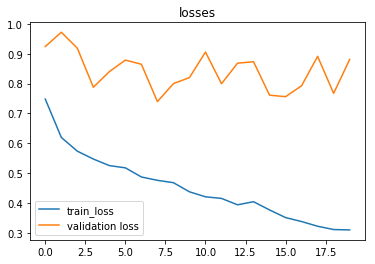

In [24]:
trainer.trainIters(input_source_padded,input_target_padded,val_source_padded,val_target_padded)

# test

In [0]:
ret=trainer.translateIter(val_source_padded[:10])

In [26]:
ret1 = trainer.translateIter(val_source_padded[:20])
for src,pred,target in zip(val_data[src_col],ret1,val_data[trg_col]):
    print("src->",src)
    print()
    print("pred->"," ".join(Langs["trg"].id2word(pred)))
    print("ans->",target)
    print("------------------")

src-> theres no need to hurry.

pred-> それ は 意見 は ない 。 EOS は ない 。 EOS は ない 。 EOS 。 EOS は ない 。
ans-> 急ぐ 必要 は あり ませ ん 。
------------------
src-> i want to join your band.

pred-> 私 に 行き たい 。 EOS に 行き たい 。 EOS に 行き たい 。 EOS に 行き たい 。
ans-> あなた の バンド に 入り たい な 。
------------------
src-> you must keep an eye on the child.

pred-> あなた は 子供 は 子供 を 脱が ば なら ない 。 EOS を なら ない 。 EOS を なら ない
ans-> その 子 から 目 を 離さ ない よう に し なけれ ば いけ ない 。
------------------
src-> he is mad about music.

pred-> 彼 は まだ まだ を 夢中 を 夢中 。 EOS を 夢中 。 EOS を 夢中 。 EOS 。 EOS
ans-> 彼 は 音楽 狂 だ 。
------------------
src-> with a little more patience she would have succeeded.

pred-> もう少し 我慢強けれ 我慢強けれ し た 。 EOS き た 。 EOS き た 。 EOS き し た 。 EOS
ans-> もし 彼女 が もう少し 我慢強かっ たら 、 成功 し て い た だろ う に 。
------------------
src-> they painted the fence green.

pred-> 彼ら は 生活 を し た 。 EOS を し た 。 EOS を し た 。 EOS し た
ans-> 彼ら は フェンス を 緑色 に 塗っ た 。
------------------
src-> there was a convention last month.

pred-> 昨日 は 昨日 は 昨日 日 日 日 日 日 日 日 日 日 日 日 日 日 日

In [27]:
ret2 = trainer.translateIter(input_source_padded[:20])
for src,pred,target in zip(data[src_col],ret2,data[trg_col]):
    print("src->",src)
    print()
    print("pred->"," ".join(Langs["trg"].id2word(pred)))
    print("ans->",target)
    print("------------------")

src-> its tom.

pred-> トム は トム です 。 EOS です 。 EOS です 。 EOS です 。 EOS です 。 EOS です 。
ans-> トム だ 。
------------------
src-> id like to introduce you to some of my friends.

pred-> トム を し たい の です EOS の し たい 。 EOS です EOS です EOS 。 EOS です EOS
ans-> あなた を 私 の 友達 に 紹介 し たい の です が 。
------------------
src-> please be careful.

pred-> 水 を し て ください 。 EOS ください 。 EOS ください 。 EOS ください 。 EOS ください 。 EOS ください
ans-> 気 を つけ て ください 。
------------------
src-> he knows no english not to mention german.

pred-> 彼 は 英語 語 語 語 語 語 語 語 語 語 語 語 語 語 語 語 語 語
ans-> 彼 は ドイツ 語 は 言うまでもなく 、 英語 も 知ら ない 。
------------------
src-> i explained the rules to her.

pred-> 私 は 彼女 を 彼女 を し た 。 EOS し た 。 EOS を し た 。 EOS を
ans-> 私 は 彼女 に 規則 を 説明 し た 。
------------------
src-> the titanic sunk on its maiden voyage.

pred-> タイタニック 号 号 号 で 処女 れ た 。 EOS 号 で 処女 れ た 。 EOS 号 で 処女
ans-> タイタニック 号 は 処女 航海 で 沈没 し た 。
------------------
src-> tom walked all day.

pred-> トム は 結局 結局 入力 し た 。 EOS を 入力 し た 。 EOS し た 。 EOS を
ans-> トム は 一 日 中 歩き 続け た 。